## <center> Text Mining for Social Sciences <center>
<center> Exercise 3<center>
<center> April, 2019<center>
<center> Maia Brenner <center>

In [10]:
#! pip install --quiet gensim

In [47]:
import warnings 
warnings.filterwarnings('ignore')

In [48]:
import pandas as pd
yelps = pd.read_csv('sentiment/yelps.csv')

In [49]:
yelps.head(1)

,business_id,positive,text
0,oT1QxDuFdBlPUEMnySAJwA,True,First time here. Always wanted to try. Interes...


In [50]:
yelps.shape

(100000, 3)

In [51]:
#yelps.positive

In [52]:
##I take a sample of the data because if not it takes too long
yelps = yelps.sample(10000) 

In [53]:
from bs4 import BeautifulSoup
import re

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    
    #Regular expression used as default in sk.learn denoting what constitutes a “token”:
    token_pattern = r"(?u)\b\w\w+\b"
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(s)

    pass

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a count vectorizer, using the preprocessor and tokenizer from above
vectorizer = CountVectorizer(preprocessor = clean_yelp, tokenizer = tokenize)
TF_matrix = vectorizer.fit_transform(yelps.text) # TF matrix

# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.

# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

svd = TruncatedSVD(n_components = 100)
SVD_matrix = svd.fit_transform(TF_matrix) # truncated matrix

In [56]:
# 1. The original TF matrix
#print(TF_matrix)

In [57]:
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD
#print(SVD_matrix)

In [58]:
# Function to test vector representations 
# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

from sklearn.metrics import accuracy_score

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [59]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import math

# I test my vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

length = len(yelps.positive)

levels = []
for level in np.arange(0.005, 1, 0.10):
    levels.append(math.floor(length*level))  # creating the set of cutoff levels


accuracy_TF = [test_holdout_vectors(TF_matrix, yelps.positive, l) for l in levels]     # accuracy for TF
accuracy_PCA = [test_holdout_vectors(SVD_matrix, yelps.positive, l) for l in levels]   # accuracy for SVD


## Plot that compares the accuracy with the two different word embeddings (TF and SVD)

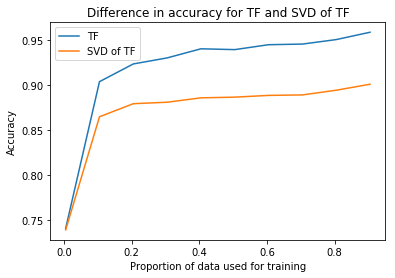

In [60]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0.005, 1, 0.10),accuracy_TF)
plt.plot(np.arange(0.005, 1, 0.10),accuracy_PCA)
plt.tick_params(axis = 'both', which = 'major')
plt.legend(['TF','SVD of TF'])
plt.title("Difference in accuracy for TF and SVD of TF")
plt.xlabel('Proportion of data used for training')
plt.ylabel('Accuracy')
plt.show()

## We can observe that the word embeddings generated by the SVD does not improve our accuracy score

In [62]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 

sentences = [tokenize(clean_yelp(review)) for review in yelps.text]
model = Word2Vec(sentences=sentences, size=100, window=5, min_count=1, workers=3)
model.train(sentences, total_examples=1, epochs=2)

(1699155, 2209086)

In [63]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

In [64]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a


# use as follows: np.array([embed_w2v(t, w2v) for t in X])

In [65]:
levels

[50, 1050, 2050, 3050, 4050, 5050, 6050, 7050, 8050, 9050]

In [66]:
w2v_matrix = np.array([embed_w2v(t, model) for t in sentences])
accuracy_w2v = [test_holdout_vectors(w2v_matrix, yelps.positive, l) for l in levels]

## Plot that compares the accuracy between the three different word embeddings (TF, SVD, Word2Vec)

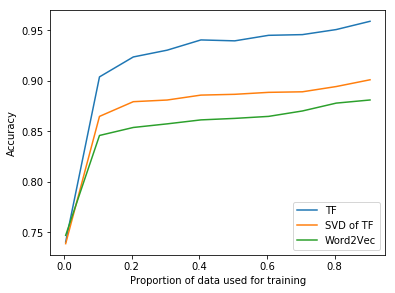

In [67]:
plt.figure(figsize=(6,4.5))
plt.plot(np.arange(0.005, 1, 0.10),accuracy_TF)
plt.plot(np.arange(0.005, 1, 0.10),accuracy_PCA)
plt.plot(np.arange(0.005, 1, 0.10),accuracy_w2v)
plt.tick_params(axis = 'both', which = 'major')
plt.legend(['TF','SVD of TF', 'Word2Vec'])
plt.xlabel('Proportion of data used for training')
plt.ylabel('Accuracy')
plt.show()


### We observe that the Word2Vec embedding in this case is the one that performs worst. 

In [68]:
#Twitter data

In [69]:
import pandas as pd
import re
from functools import reduce

pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = s.lower()
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return s

In [70]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [71]:
tweets.shape

(765246,)

In [72]:
tweets.head(10)

0                                Follow your dreams.\n
1    Ashley Madison stats find New Orleans among th...
2    RT @PigeonToday: Call me a hater if you want, ...
3    RT @AnnCoulter: Former Hialeah Mayor Julio Mar...
4    RT @HuffPostPol: Rick Perry's campaign staff i...
5    RT @WillysBaldSpot: #CrookedHillary #LyingHill...
6    RT @jko417: TRUMP NOW LEADS ABC POLL THAT CLAI...
7    RT @ElianaBenador: FINALLY‼️ RABID ISLAMIST HA...
8    RT @IainPageFox29: At least 60 dead, mostly wo...
9    RT @CathyTo47590555: #terrorists #IslamExposed...
dtype: object

In [122]:
tweets[5]

'RT @WillysBaldSpot: #CrookedHillary #LyingHillary #NeverHillary https://t.co/uu2HatOveS\n'

In [120]:
cleaned_tweet= clean_twitter(tweets[5])
cleaned_tweet

'#crookedhillary #lyinghillary #neverhillary'

In [73]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 

vectorizer_tweets = CountVectorizer(preprocessor=clean_twitter, tokenizer = tokenize)
TF_tweets = vectorizer_tweets.fit_transform(tweets) 
svd = TruncatedSVD(n_components = 100)
SVD_tweets = svd.fit_transform(TF_tweets) 


sentences_tweets = [tokenize(clean_twitter(tweet)) for tweet in tweets]
model_tweets = Word2Vec(sentences_tweets, size=100, window=5, min_count=1, workers=4)


In [74]:
w2v_tweets  = np.array([embed_w2v(t, model_tweets) for t in sentences_tweets]) # new embeddings

### Most similar words to Hilary

In [75]:
display(model_tweets.wv.most_similar('hillary'))

[('hrc', 0.7533363103866577),
 ('sanders', 0.6957203149795532),
 ('she', 0.6688804030418396),
 ('hilary', 0.6441539525985718),
 ('foundation', 0.6363143920898438),
 ('nottrustworthy', 0.6223868131637573),
 ('crookedhillary', 0.6203203797340393),
 ('killary', 0.61255943775177),
 ('her', 0.6089979410171509),
 ('fastcompany', 0.6011184453964233)]

### Most similar words to Trump

In [76]:
display(model_tweets.wv.most_similar('trump'))

[('trumps', 0.6702483892440796),
 ('he', 0.6041980981826782),
 ('gop', 0.5976839065551758),
 ('hillary', 0.5974091291427612),
 ('obama', 0.5906185507774353),
 ('the', 0.5769923329353333),
 ('campaign', 0.5721060037612915),
 ('him', 0.566106379032135),
 ('sanders', 0.5575295686721802),
 ('rubio', 0.5572185516357422)]

In [77]:
display(model_tweets.wv.most_similar(positive=['trump'], negative=['hillary']))

[('rumsfe', 0.48174601793289185),
 ('south', 0.47117313742637634),
 ('francis', 0.43337884545326233),
 ('koreanupdates', 0.4284900426864624),
 ('bushfa', 0.42544129490852356),
 ('usnavys', 0.42083656787872314),
 ('eiffel', 0.42008155584335327),
 ('north', 0.41735097765922546),
 ('paro', 0.4114032983779907),
 ('toured', 0.4088643789291382)]

In [78]:
display(model_tweets.wv.most_similar('iraq'))

[('libya', 0.8470945358276367),
 ('yemen', 0.8350882530212402),
 ('afghanistan', 0.8075233697891235),
 ('syria', 0.7932569980621338),
 ('raqqa', 0.7688184380531311),
 ('egypt', 0.7397665977478027),
 ('mosul', 0.7394949197769165),
 ('aleppo', 0.7291659116744995),
 ('saa', 0.7083607912063599),
 ('militants', 0.6906678676605225)]

In [45]:
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

##I build a feature to better observe similarities among words
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

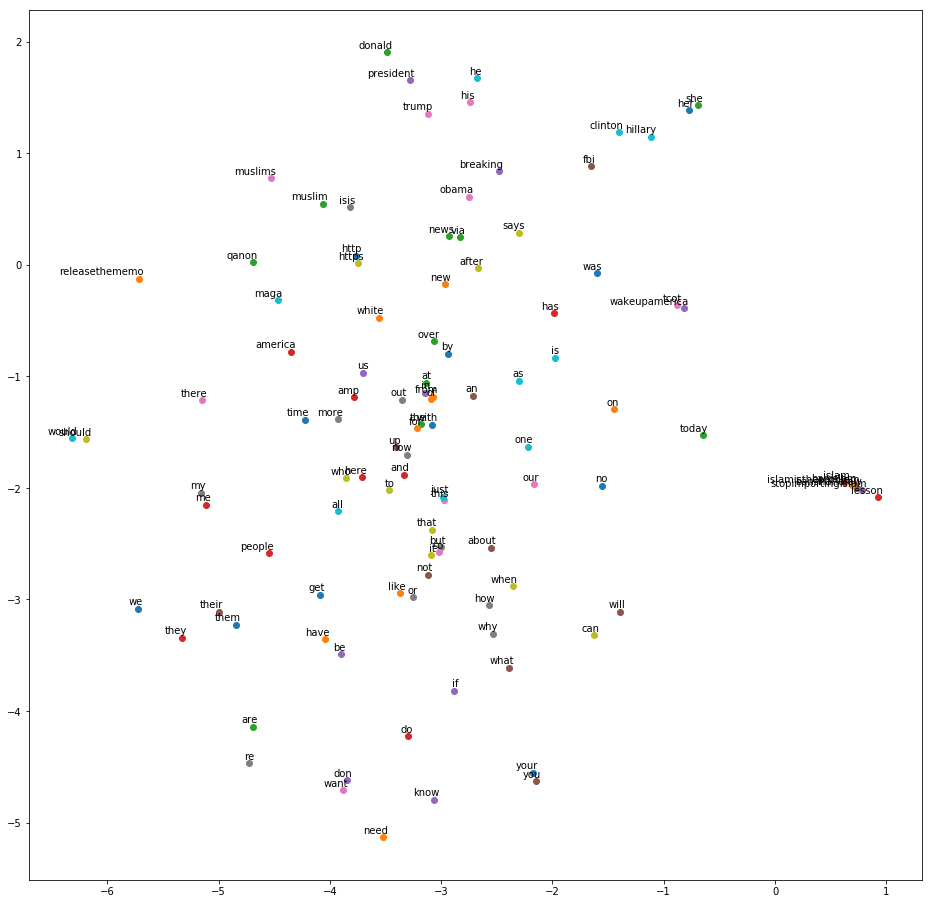

In [46]:
model_tweets_2 = Word2Vec(sentences_tweets, size=100, window=5, min_count=10000, workers=4)
tsne_plot(model_tweets_2)

In [ ]:
# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

In [102]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]), vmin=0, vmax=1)

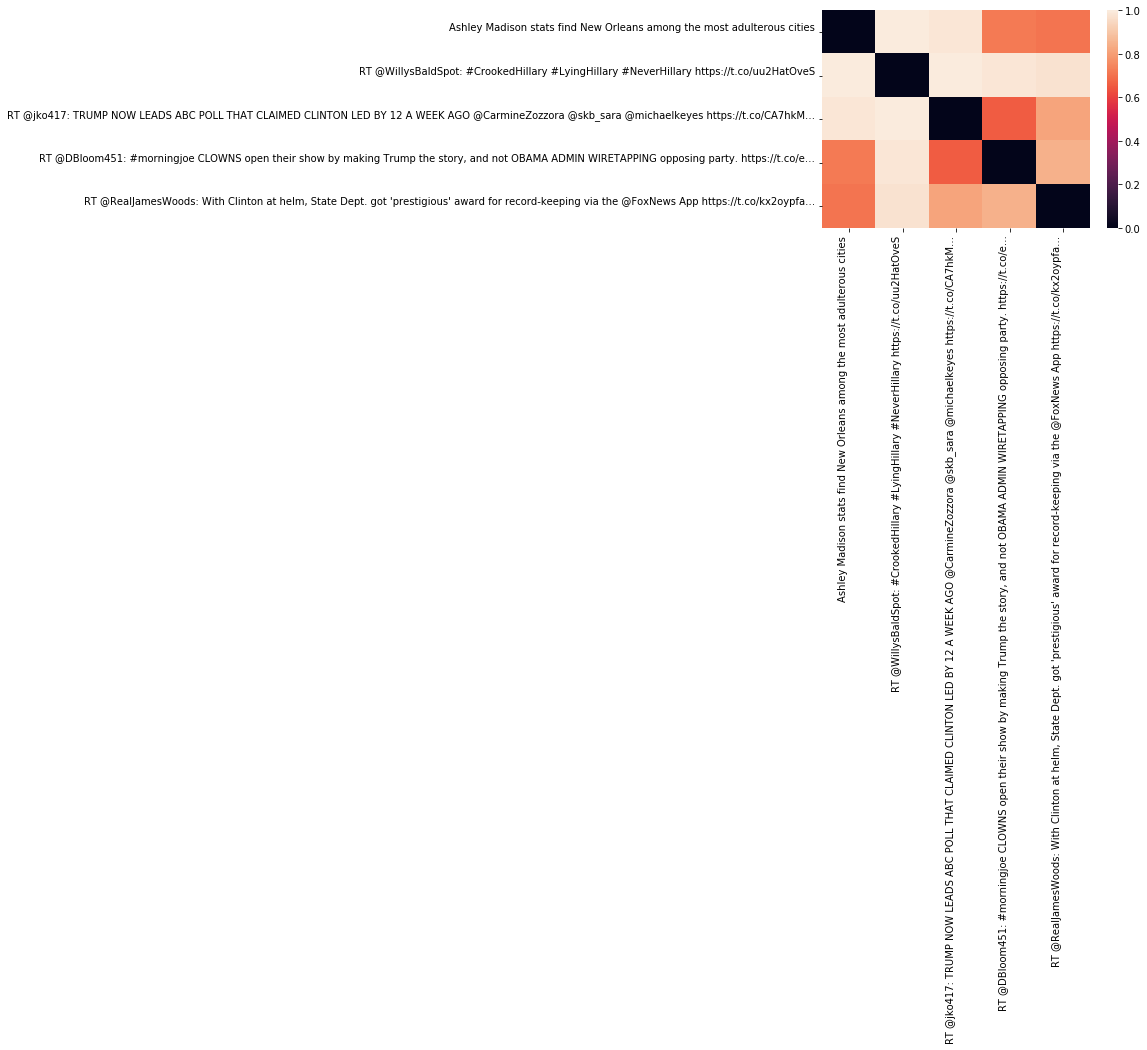

In [127]:
visualize_dist(SVD_tweets, tweets, [1,5,6,11,13])

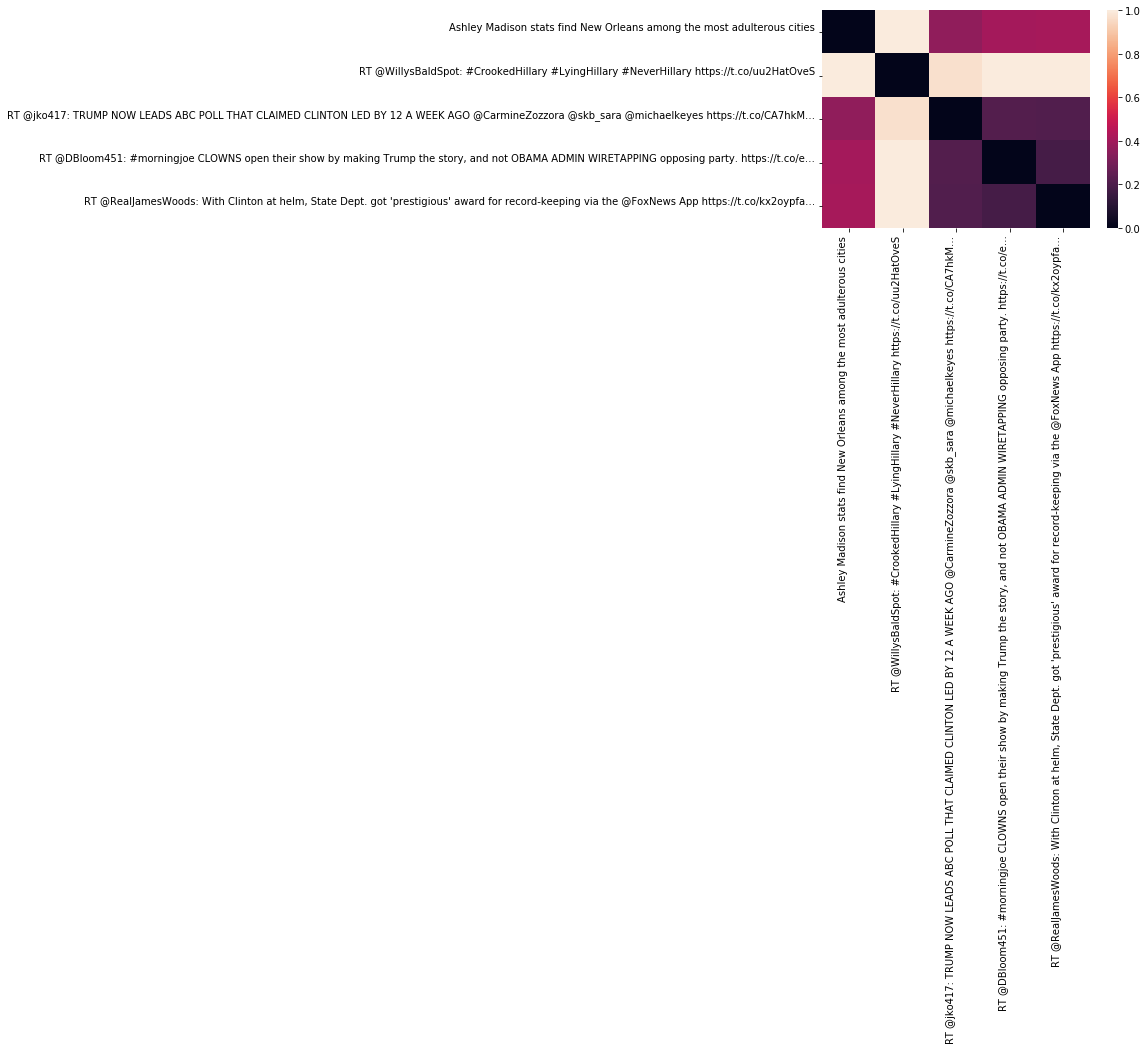

In [128]:
visualize_dist(w2v_tweets, tweets, [1,5,6,11,13])

### We can observe that tweet 5 seems to be the most disimilar to all the other tweets (for both words embedding). Which makes total sense in the sample of tweets we observed. Tweet 5 is the only one naming Hillary and it has a strong negative opinion of her reflected on the hashtags used

In [106]:
# A more clear example to observe the distance among tweets
tweets[20]

'RT @ErikBlayer: Bush Cheney Rockefeller Invaded Iraq without provocation Killed hundreds of thousands https://t.co/MBQWzSlghd https://t.co…\n'

In [107]:
tweets[22]

'RT @ParksKMBZ: Thanks Obama "@jaketapper: AP: The Taliban now hold more ground in Afghanistan than at any point since 2001 https://t.co/yNO…\n'

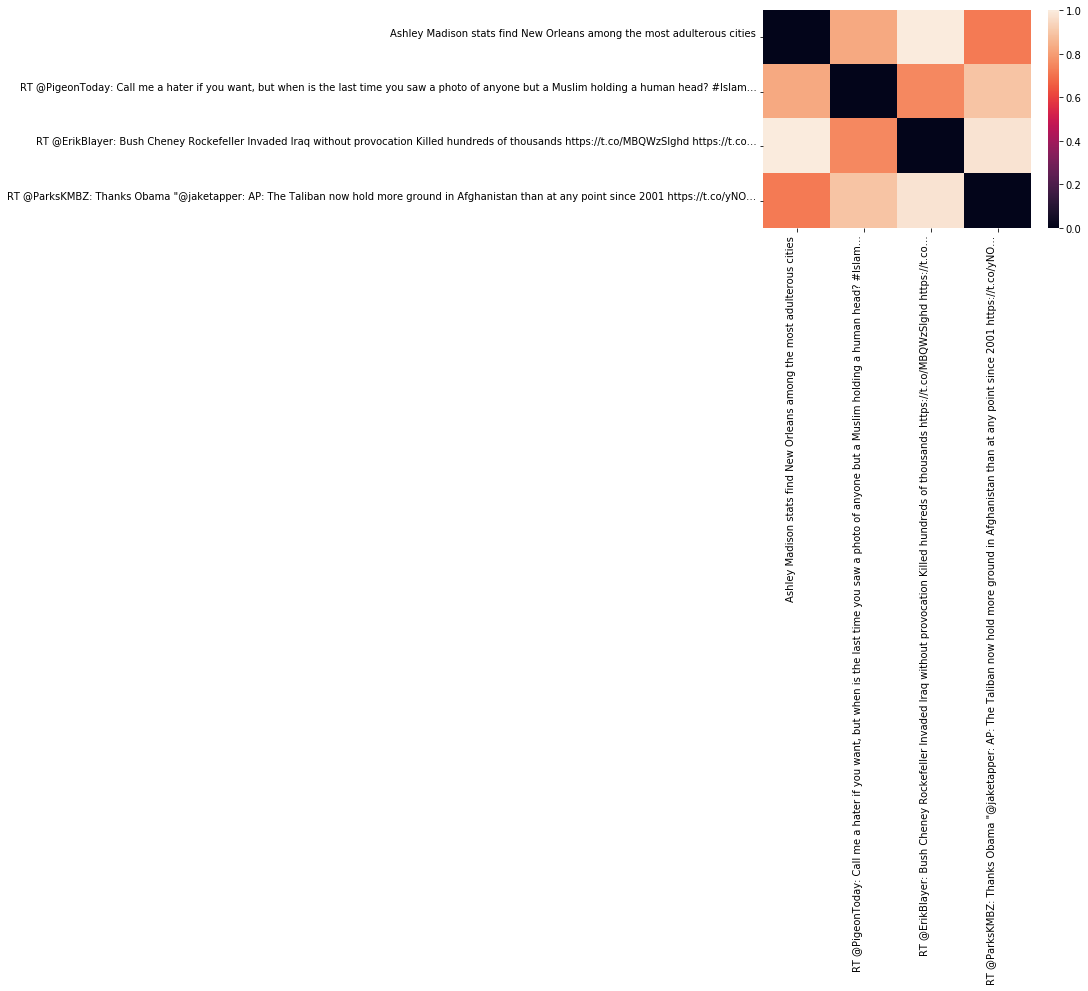

In [133]:
visualize_dist(SVD_tweets, tweets, [1,2,20,22])

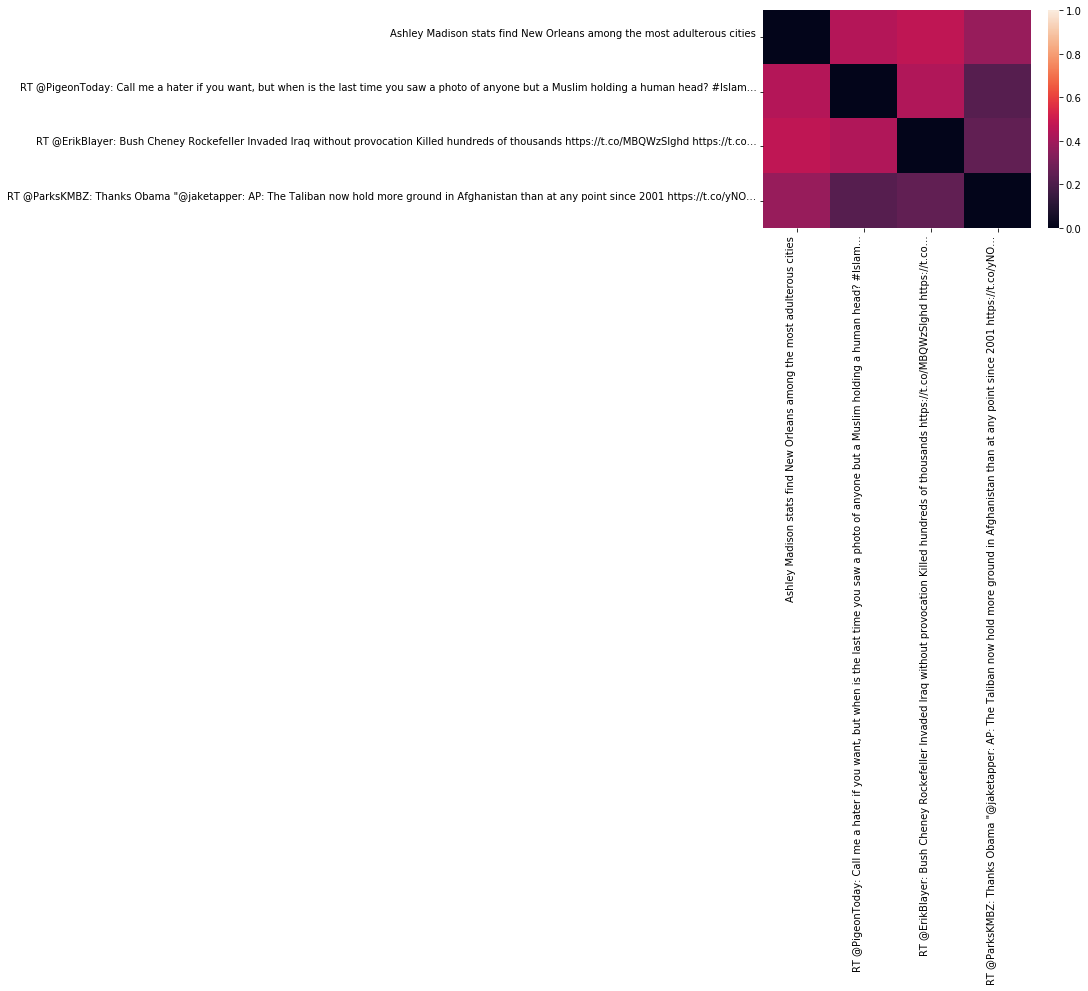

In [132]:
visualize_dist(w2v_tweets, tweets, [1,2,20,22])

### This is an other interesting example which shows that with the SVD embedding these tweets appear to be very disimilar while with the word2vec embedder they seem to be very similar.